In [1]:
import os
import sys

current_working_directory = os.getcwd()
project_directory = os.path.dirname(os.path.dirname(current_working_directory))
utils_path = os.path.join(project_directory, 'utils')
plotting_path = os.path.join(project_directory, 'plotting_templates')
if utils_path not in sys.path:
    sys.path.append(utils_path)

In [2]:
import jax
jax.config.update("jax_enable_x64", True) # Enable 64-bit double precision

# Imports
import jax.numpy as jnp
from jax.numpy import fft
from jax import random, vmap, jit, grad
import jax.scipy as scipy


import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# Utilities
from utils_rough_pde import *
from utils_elliptic_coef import *
from utils_DST import discrete_sine_transform, vmap_dst, vmap_compute_sine_coef, compute_sine_coefficients
from utils_error import compute_1d_error

In [3]:
plt.style.use(plotting_path + '/plot_style-Examples.txt')
width = 4
height = width * 3 / 4

# Solving a 1d Linear elliptic PDE with a kernel method
This notebook shows the computation of a 1D Linear elliptic PDE with rough forcing using a kernel method (section 4.2.1).

## Using the DST for solving an elliptic PDE

We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + b(x)u &= \xi \\
u &= 0
\end{aligned}
with $b(x) = 1$.

If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

Our domain will be $[0,1]$ and so $L = 1.0$. Therefore

\begin{aligned}
\xi &=   \sqrt{2} \sum_{i}^\infty \xi_i \sin\Big(n\pi x\Big) \\
u &=  \sqrt{2}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)}\sin\Big(n\pi x\Big)
\end{aligned}


In [4]:
# Generate a solution and forcing term
key = random.PRNGKey(635)
nu = 0.01


n_coef = 2**14
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
print("We use {} basis functions for the solution and the forcing term".format(n_coef))

frequencies = jnp.arange(0, n_coef) + 1
coef_f = jnp.hstack([random.normal(key, shape= (n_coef,))])
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = discrete_sine_transform(coef_f)
u_values = discrete_sine_transform(coef_u)

We use 16384 basis functions for the solution and the forcing term


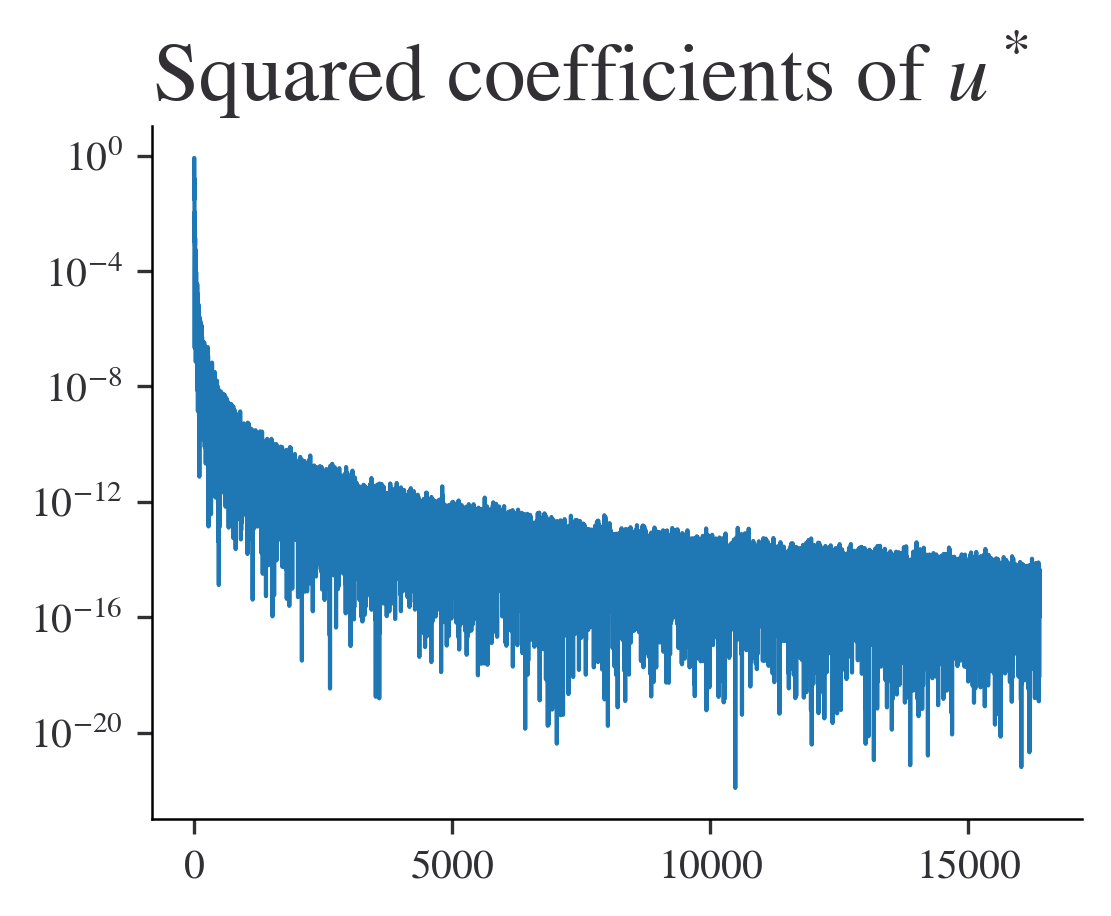

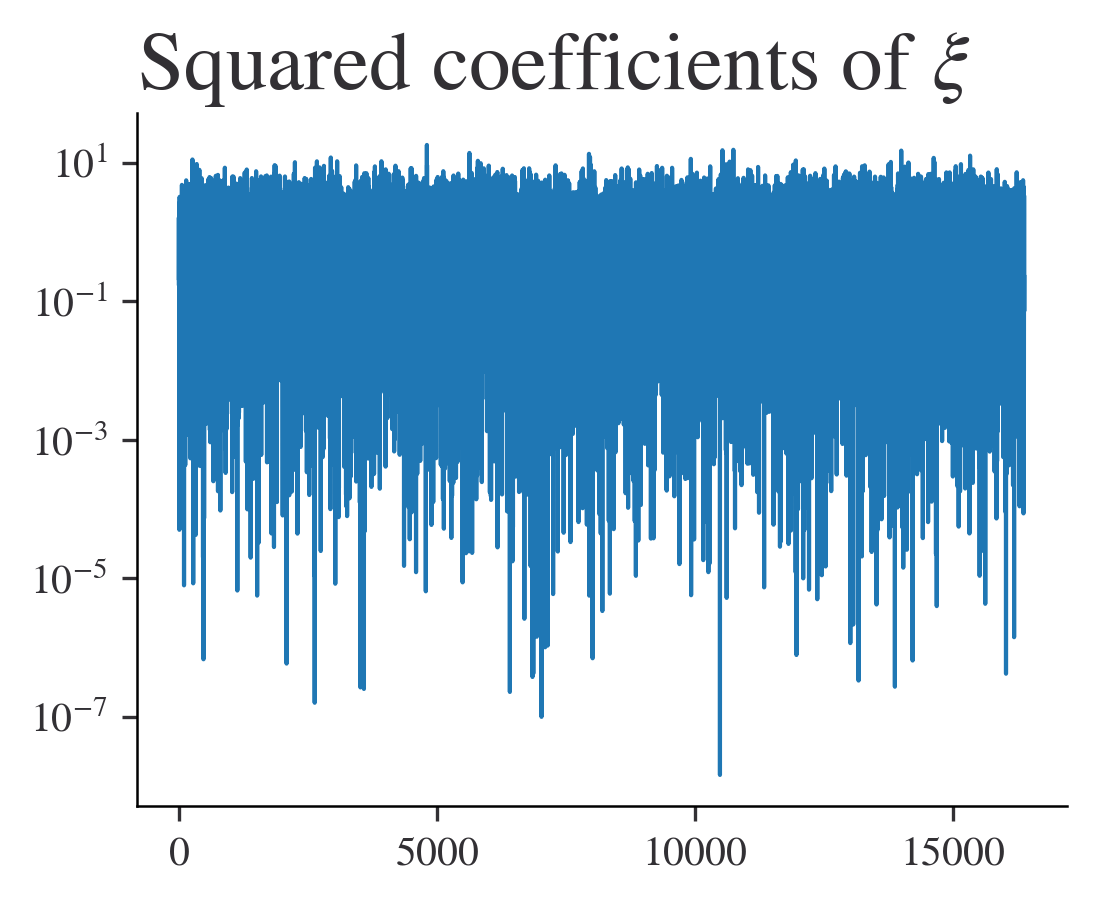

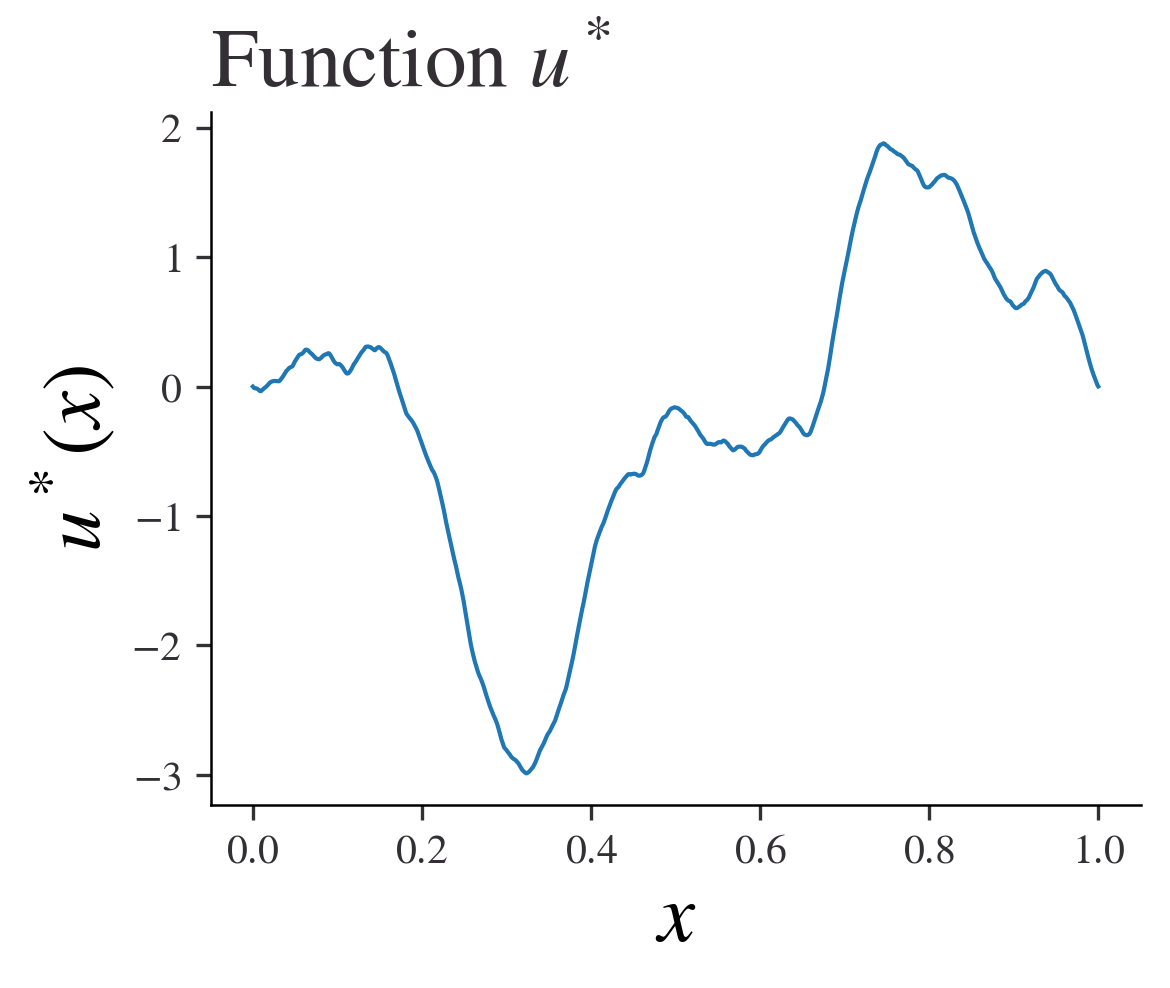

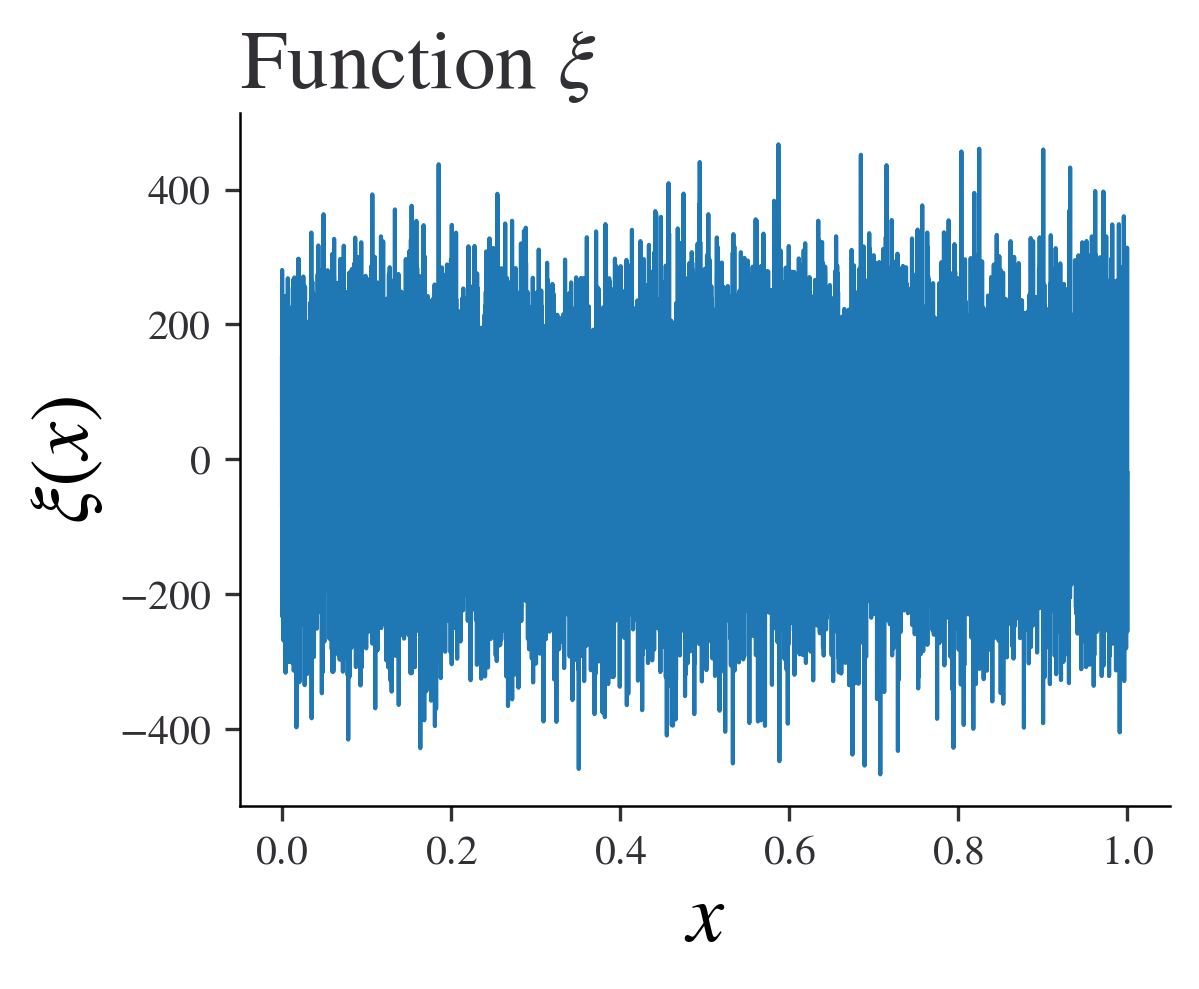

In [5]:
# Plot both the coeffients of u and f in 2 subplots
fig = plt.figure(figsize=(width, height))
plt.plot(coef_u**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $u^*$')


plt.show()

fig = plt.figure(figsize=(width, height))
plt.plot(coef_f**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $\xi$')
plt.show()

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u^*(x)$")
plt.title(r"Function $u^*$")

fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, f_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.gca().autoscale() 
plt.show()

## Computing a kernel solution using a $H^{-1}$ norm

In [6]:
from utils_elliptic_coef import L_b_xy, vmap_L_b_xy, vmap_L_b_y
b =lambda x : jnp.ones_like(x)*1.0 # Constant coefficient b(x) = 1

n_meas = 2**12
print("We use {} test functions".format(n_meas))
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
length_scale = 1.0

We use 4096 test functions


In [7]:
def solve_linear_pde(domain_measurements):
    # Build the kernel matrix
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
    theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

    # Build the linear system
    theta_22_sine = vmap_compute_sine_coef(vmap_compute_sine_coef(theta_22).T)
    theta_22_sine = theta_22_sine
    theta_12_sine = vmap_compute_sine_coef(theta_12)
    theta_12_sine = theta_12_sine
    theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

    # Solve the linear system
    reg = 1e-14 # gamma parameter in the paper
    decay = jnp.arange(n_meas) +1
    s_decay = 1.0 # Which negative Sobolev norm to use (s parameter in the paper)
    rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])
    nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*decay**s_decay]) # We impose the boundary exactly
    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Coefficients of the expansion

    return alpha

def evaluate_solution(alpha, domain_measurements):
    # Compute the prediction
    K = vmap_kernel(domain_finest, boundary, length_scale)
    K_interior = vmap_compute_sine_coef(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))
    K_interior = K_interior# remove the last spurious element
    K_eval = jnp.block([K, K_interior])
    pred = K_eval@alpha

    return pred



In [8]:
alpha = solve_linear_pde(domain_measurements)
pred = evaluate_solution(alpha, domain_measurements)

# Compute the error
e, e_rel = compute_1d_error(pred, u_values, domain_finest, domain_measurements)
print("The L^2 error is {:.2e}. The relative L^2 error is {:.2e}".format(e, e_rel))

The L^2 error is 4.92e-05. The relative L^2 error is 3.95e-05


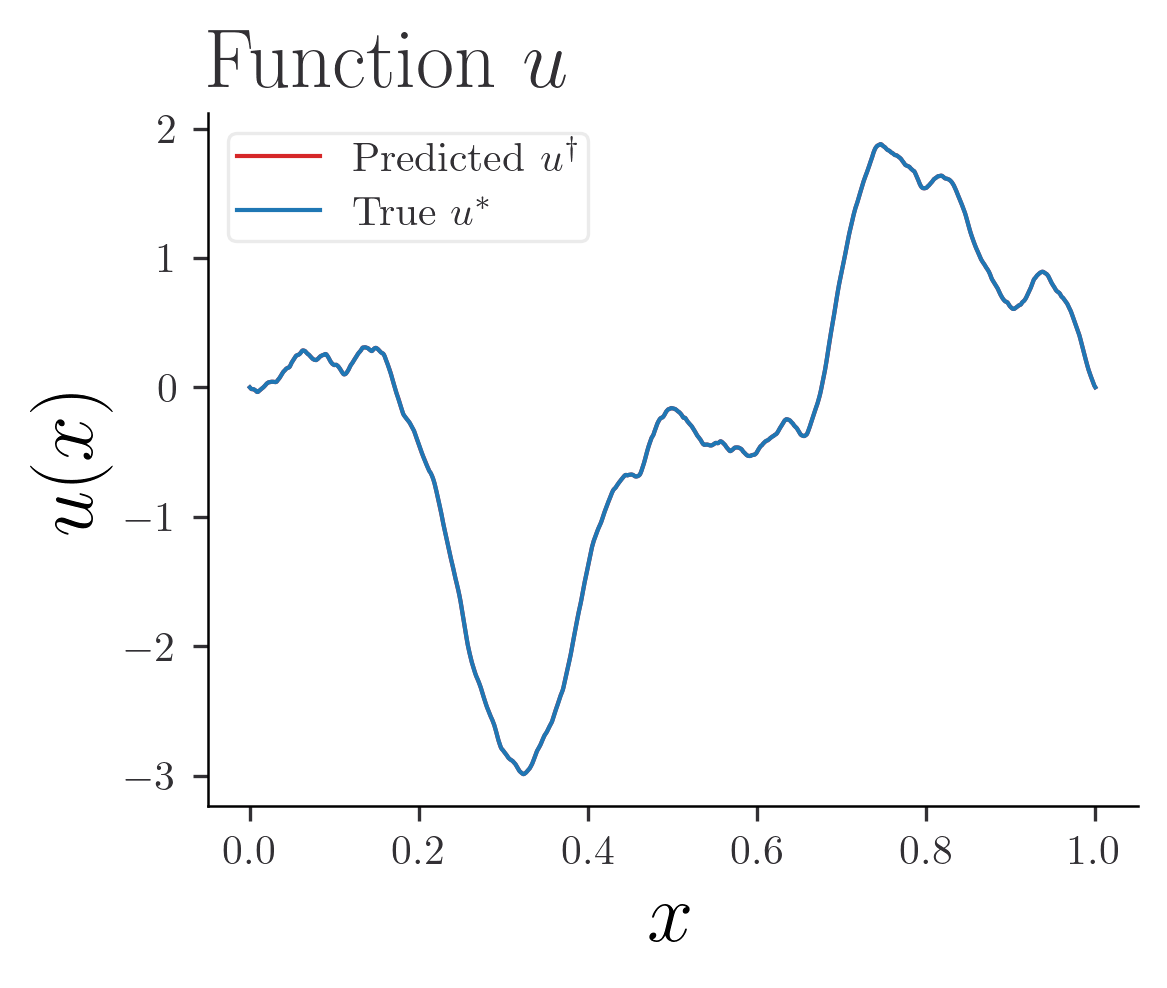

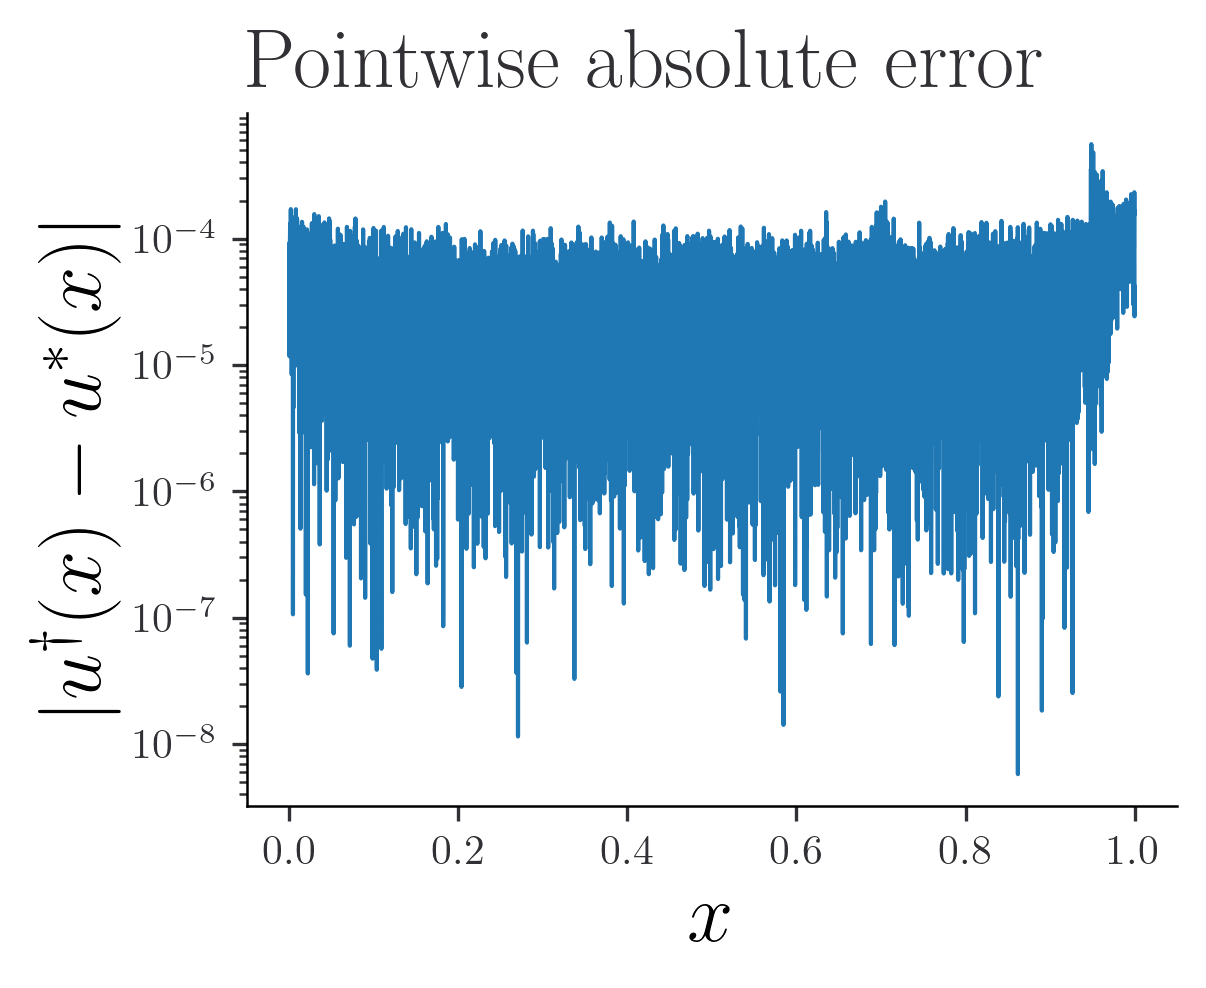

In [28]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


## Computing a solution using pointwise values 

See https://arxiv.org/abs/2103.12959 for a desciption of this methodology.

In [29]:
ratio = int(n_coef/n_meas)
f_obs = f_values[::ratio] # Pointwise observations of the forcing term

In [30]:
def solve_linear_pde_pointwise(domain_measurements):
    # Build the kernel matrix, we do not compute the DST
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
    theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))
    theta = jnp.block([[theta_11, theta_12], [theta_12.T, theta_22]])


    # Solve the linear system
    reg = 1e-14
    rhs = jnp.concatenate([jnp.zeros_like(boundary), f_obs])
    nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*jnp.ones(n_meas)])
    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Solve the linear system

    return alpha

def evaluate_solution_pointwise(alpha, domain_measurements):
    # Compute the prediction
    K = vmap_kernel(domain_finest, boundary, length_scale)
    K_interior = vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements))
    K_eval = jnp.block([K, K_interior])
    pred = K_eval@alpha

    return pred


In [31]:
alpha_pointwise = solve_linear_pde_pointwise(domain_measurements)
pred_pointwise = evaluate_solution_pointwise(alpha_pointwise, domain_measurements)
e, e_rel = compute_1d_error(pred_pointwise, u_values, domain_finest, domain_measurements)
print("The L^2 error is {:.2e}. The relative L^2 error is {:.2e}".format(e, e_rel))

The L^2 error is 2.10e+00. The relative L^2 error is 1.68e+00


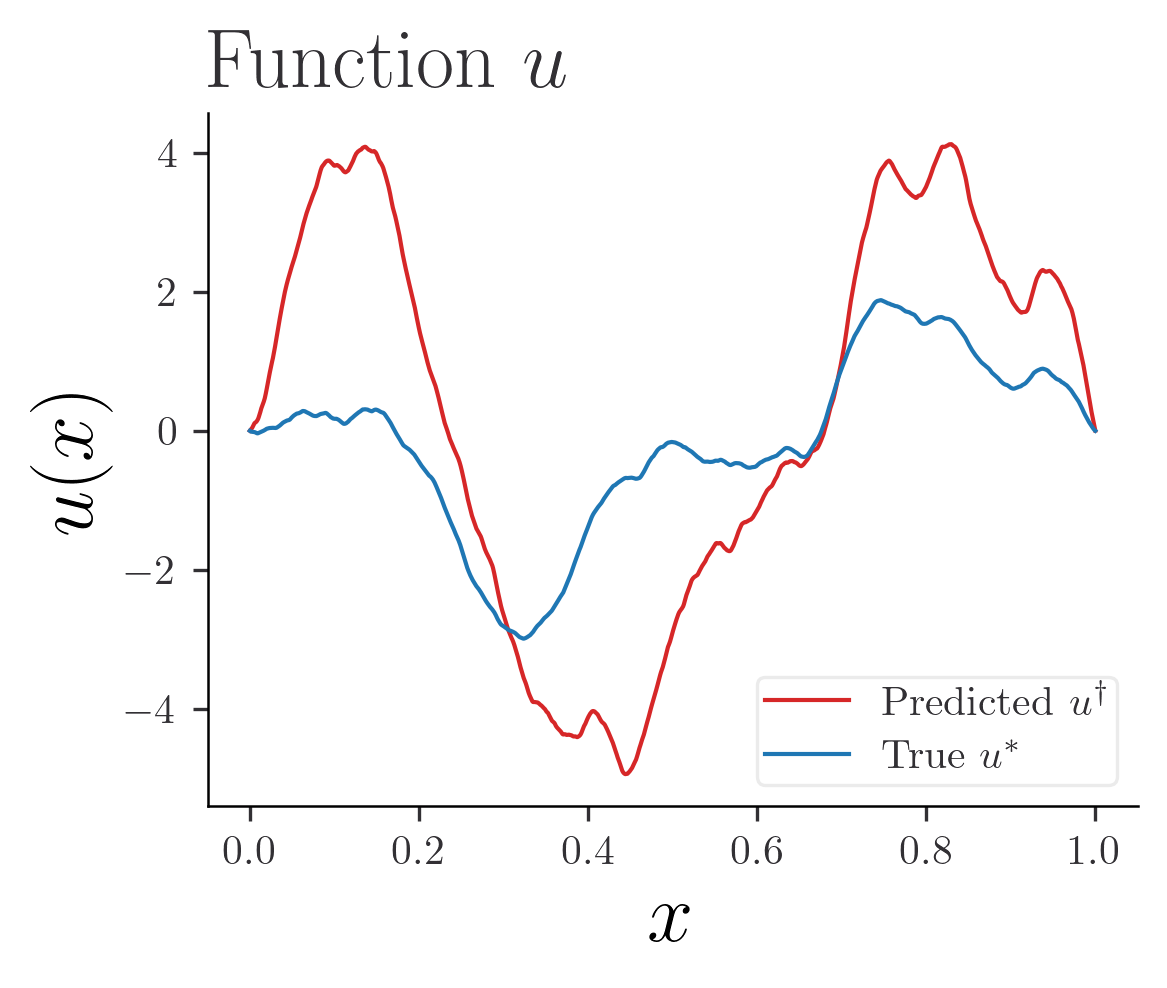

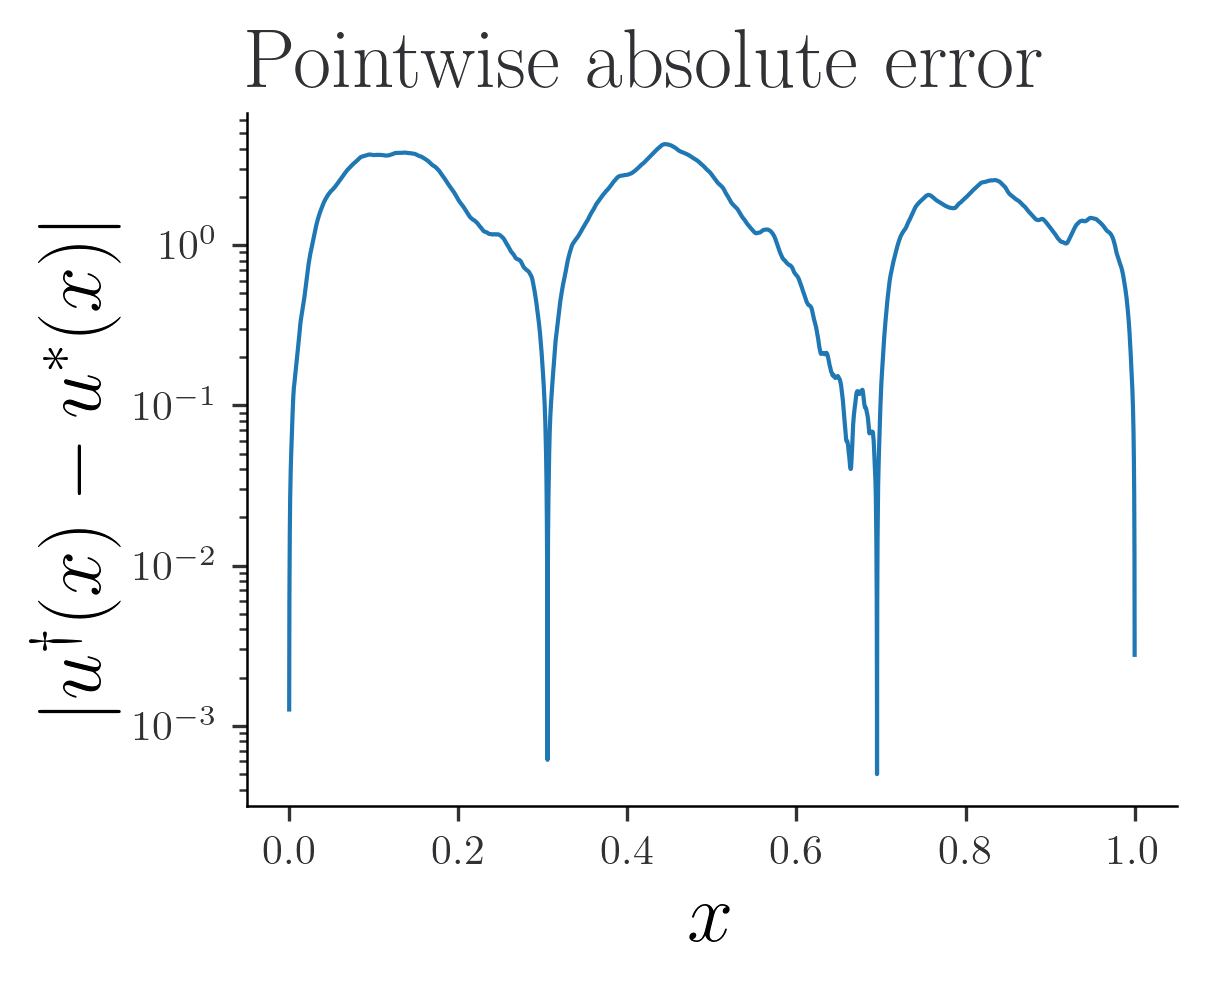

In [32]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred_pointwise, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred_pointwise - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()

# Computing error rates

In [33]:
meas_exp = jnp.arange(4, 13)
length_scale = 1.0
error = []
error_rel = []

freq_error = []
freq_error_rel = []

reg = 1e-10


predictions = []
for i in tqdm(meas_exp):
    n_meas = 2**i

    domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
    alpha = solve_linear_pde(domain_measurements)
    pred = evaluate_solution(alpha, domain_measurements)

    predictions.append(pred)

    # Computing the error in the Fourier domain
    L2_error, relative_L2_error = compute_1d_error(pred, u_values, domain_finest, domain_measurements)

    error.append(L2_error)
    error_rel.append(relative_L2_error)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:51<00:00,  5.77s/it]


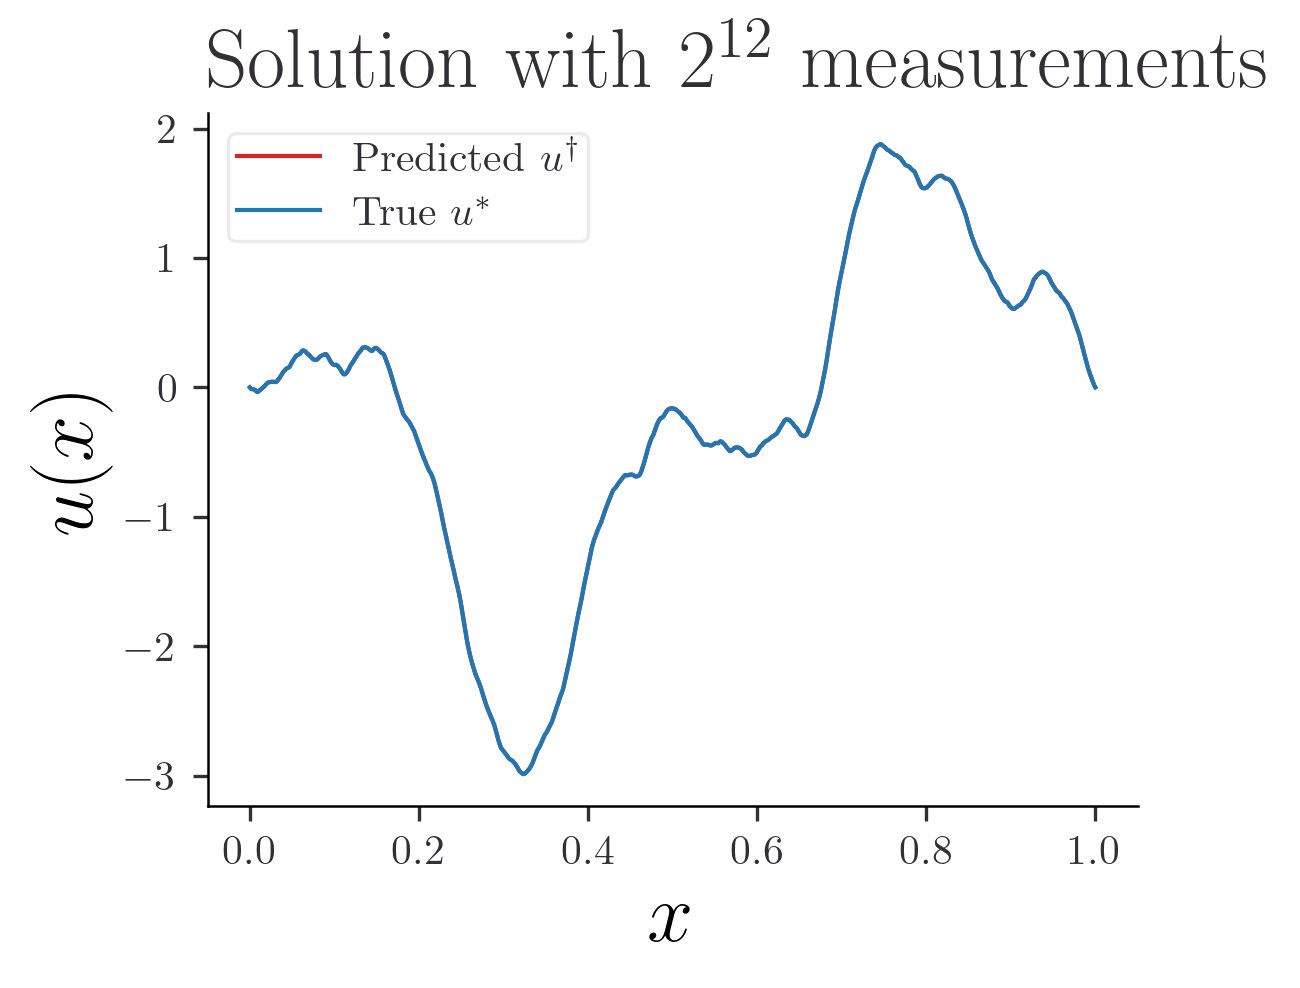

In [34]:
figure = plt.figure(figsize=(width, height))

plt.plot(domain_finest, predictions[-1], label = r"Predicted $u^\dagger$", color = 'tab:red')

plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Solution with $2^{"+str(meas_exp[-1])+"}$ measurements")
plt.legend()
plt.show()


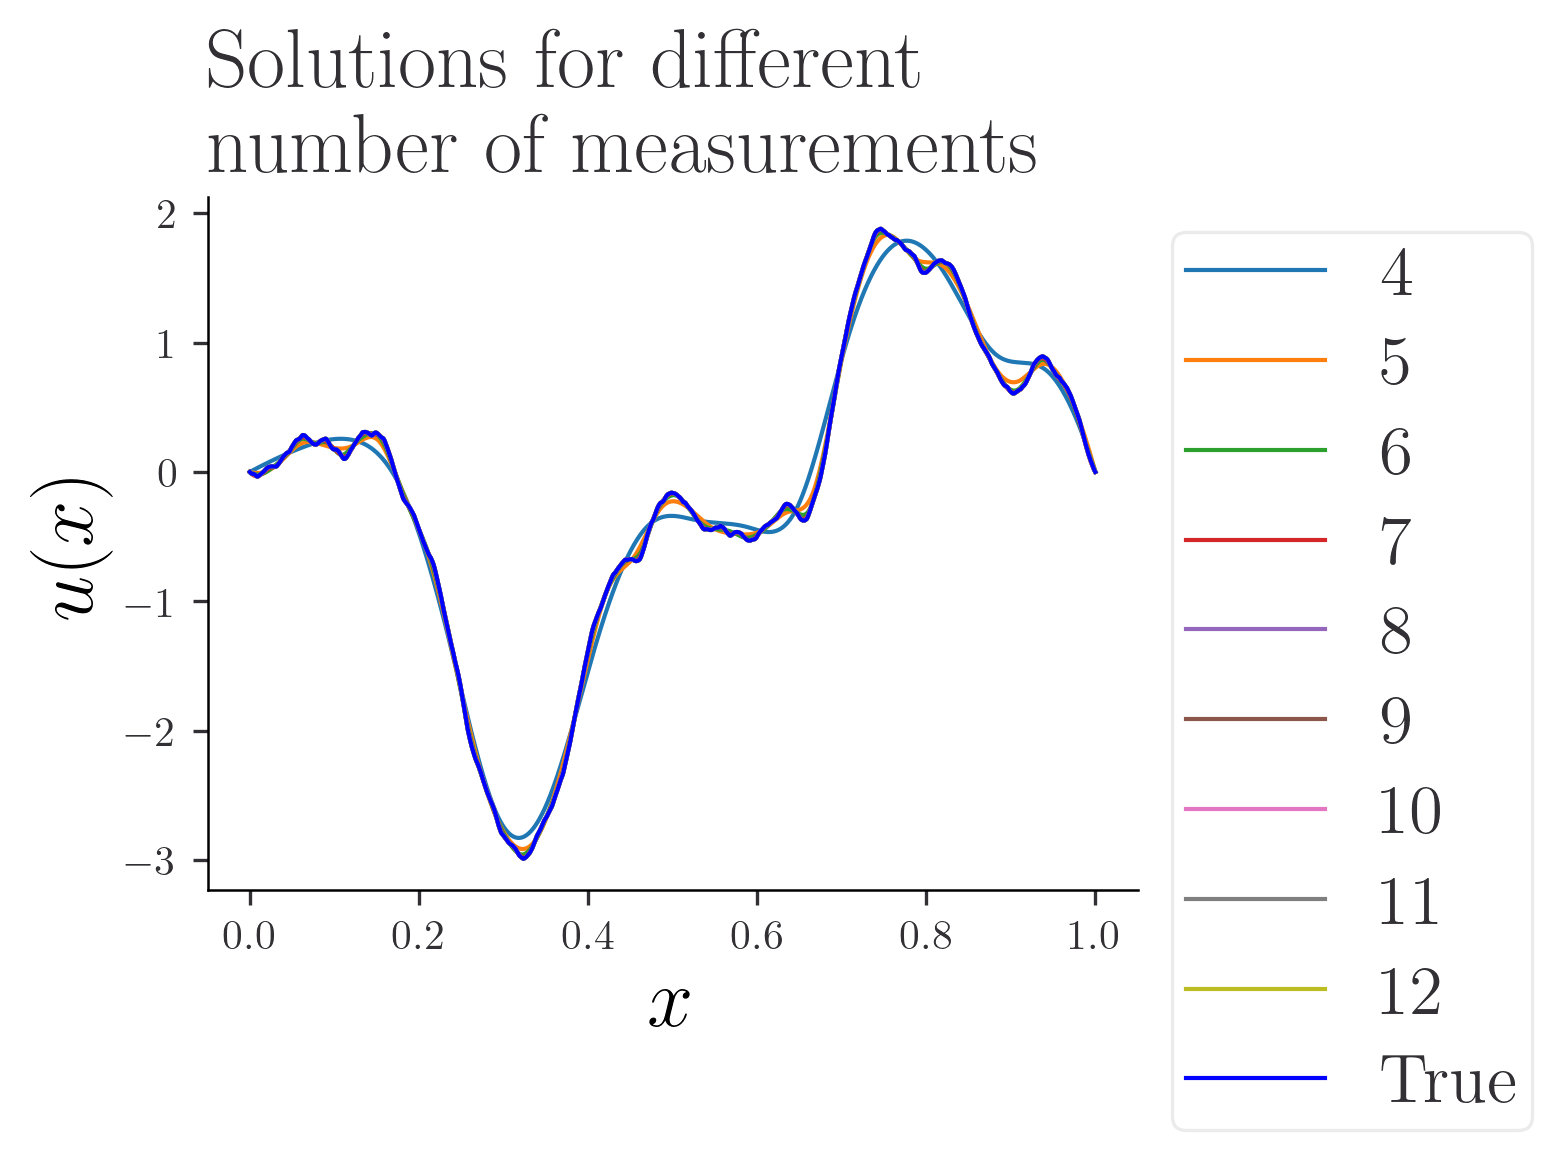

In [35]:
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp):
    plt.plot(domain_finest, predictions[i], label = r"${"+str(j)+"}$")

plt.plot(domain_finest, u_values, label = "True", color = 'blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title("Solutions for different \n number of measurements")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.show()


In [36]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  1.408


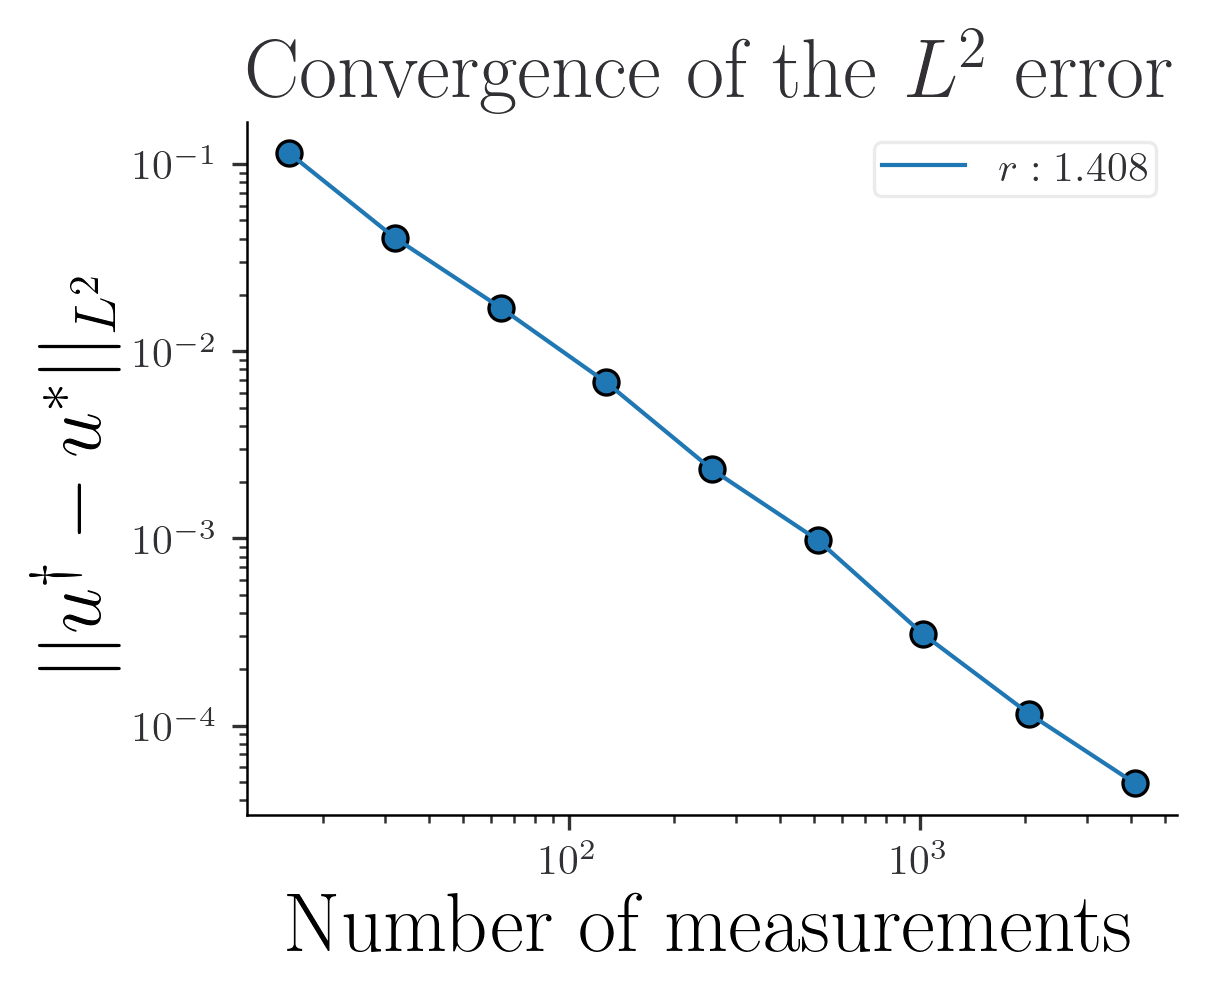

In [37]:
fig = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(2**meas_exp, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()
